# Tutorial 2 - Optimal pendulum swing-up with Pyomo

**Aim:** To create an optimization model from the double pendulum we've constructed in symbolic toolbox, and solve it for the optimal swing-up motion.

**Further reading:** <a href = http://www.matthewpeterkelly.com/tutorials/trajectoryOptimization/index.html> This blog is a perfect introduction to trajectory optimization that will give you a solid overview of the problem and all the terminology you need. Matthew Kelly is a good dude :)</a> It might be worth checking out the <a href=https://pyomo.readthedocs.io/en/stable/>Pyomo documentation</a>, but it's a bit hit and miss... IMO the textbook 'Pyomo - Optimization Modeling in Python by William E. Hart is much better.

## Trajectory Optimization 101
**What is a trajectory?**
A trajectory is just a time series: the behaviour of one or more variables sampled over time. In our specific cases, the variables we're tracking are the ones we need to describe the motion of a system over time, and the forces that drive that motion.

**What does it mean to 'optimize' a trajectory?**
Trajectory optimization problems are often 'boundary value problems': the system has a known starting point, and a known ending point that we want it to get to. E.g. for our pendulum swing-up, we want it to start at rest hanging down at [0,0], and we want it to end at rest pointing straight up at [$\pi$,0]. 

Thing is, there are infinitely many trajectories that could get us from point A to point B: maybe the pendulum swings up clockwise... Maybe it swings up anticlockwise... Maybe it flails around in the precise way for its endpoint to write out all the lyrics to MCR's *Welcome to the Black Parade* in perfect air-cursive before getting there. The point of optimization is to find the trajectory that best minimizes some *cost function* (aka. the *objective function*).

If your objective is rapid motion, you might want to minimize the time it takes to swing up. If your objective is efficiency, you might want to minimize the torque applied over the course of the motion. Maybe you want to minimize the total horizontal space it needs to perform the manoeuvre, whatever. Part of the art of this field is finding the right cost function. (But more on that just now).

## The problem formulation
There are many different ways to do trajectory optimization, but the one we have chosen is the _transcription_ approach, where we _transcribe_ the trajectory optimization into a nonlinear programming problem (NLP). You might have encountered the basics of _linear programming_ in high school, where you probably used it to solve some kind of simple optimization, such as figuring out how many of each type of sandwich should be stocked at the tuck shop to maximize profits, subject to constraints like
- No more than 200 sandwiches can be stored at a time
- At least 40 cheese sandwiches must be available
If so, you probably remember drawing these constraints on a graph, highlighting the _feasible region_ where all of them are satisfied, and finding the point within that where you are scoring the most bread for your bread.

These linear programs were very simple: you never had more than two _decision variables_ (number of thing A, number of thing B), since this is how many you can plot on a 2D graph, and all the constraints were _linear_ i.e. able to be represented using straight lines, but they contain all the same elements of an optimization program. The difference with NLPs is that the constraints can be nonlinear. Another difference with the problems we'll be looking at is the sheer scale: they'll often have tens, or even hundreds of thousands of variables and constraints - far more than can be comfortably dealt with by hand.

Luckily, you don't need to know how to solve such a monstrosity, because smart maths people have already figured it out and made some general-purpose NLP solving algorithms - some of which are open source. So, all you need to know how to do is describe your trajectory optimization problem in terms of a NLP, and then you can use one of these solvers to find a result.

Algebraic modelling languages (AMLs), such as the Pyomo library in Python, facilitate this activity. In Pyomo, a problem is referred to as a "model": it's a big box filled with variables, constraints, parameters and a cost function. You pass the box to a solver and (eventually) get a trajectory out.

Pyomo has two types of model: a *concrete* model, where all the parameters are fixed up front, and an *abstract model*, where the values are left symbolic and you have to specify them using a configuration file before you solve. I have yet to find a good enough use case for the abstract one to bother learning how to use them; if I have to solve for say, a variety of different link lengths, I'll just hard code those changes between runs. But maybe that's just me.

**Modelling in Pyomo**
Pyomo has a cool object-oriented approach to modelling problems: the model is an object, and all the variables, constraints and everything else you need belong to it as children of the model. Unlike other AMLs I've used, this means you can create multiple unrelated models in one script. Also, the names of each child object are local, so these different models can have the same names for the same things e.g. if you had a cheetah model and a human model that both had a variable called 'torso', one would be 'cheetah.torso' and the other would be 'human.torso' so there'd be no problem.

In [1]:
# %reset # clears variables in workspace

# import libraries
# Pyomo stuff
from pyomo.environ import*
from pyomo.opt import SolverFactory
from pyomo.opt import SolverStatus, TerminationCondition

# other
import sympy as sym
import numpy as np

from IPython.display import display #for pretty printing

# create the model
m = ConcreteModel()

## Sets
Sets are a bit of a tricky concept to describe. Probably the best way to think of them is as indices. They're the dimensions we use to create multiple instances of things (variables, constraints, etc.).

Consider the time series nature of the trajectory: for each variable, we have $N$ samples of that variable over the time period. (You might see these time instances referred to as *nodes* or *collocation points* - but more on that later). If we want to simulate the pendulum over 100 nodes (e.g. from 0 to 1 second with a 0.01 second interval), it makes way more sense to define a single variable $\theta_1$ over the set $n = [1,2,...100]$ than to define 100 individual variables $\theta_{1_1}, \theta_{1_2},... \theta_{1_{100}}$.

Objects can be defined over multiple sets. How you choose to do this is really a matter of preference. For instance, one way to define our angle variables for the pendulum would be to use two separate variables, each defined over n: $\theta_1[n]$ and $\theta_2[n]$. Alternatively, you could create a link set $l = [1,2]$ and then define a single variable $\theta[n,l]$. Both accomplish the same thing.

From my experience, using more sets results in shorter, more streamlined code and less repetitive coding, but can get a bit hairy and long-winded to navigate and might mean having to write a lot of exceptions to select or exclude specific objects. I'm going to write using simpler set structures for this demo, and it might not be a bad idea to do the same until you're more comforable with pyomo, but I'm not going to tell you how to live your life.

In [2]:
N = 100 # how many points are in the trajectory
m.N = RangeSet(N) # For defining ordered/numerical sets. Works like 'range' in python.
m.L = RangeSet(2)

## Parameters
Parameters are known values in the model. They can be single instances (e.g. the gravitational constant $g$) or defined over sets (e.g. the mass for each link $m[l]$). In a concrete model, all parameter values must be initialized before it is solved.

In [3]:
m.g = Param(initialize = 9.81)
m.X0 = Param(initialize = 0.0) # position of fixed base
m.Y0 = Param(initialize = 2.0)
m.h = Param(initialize = 0.02) # time step

m.m = Param(m.L, initialize = 1.0) # mass of links
m.len = Param(m.L, initialize = 1.0) # length of links
# IMPORTANT make sure your values are declared as floats: many a long debugging session has eventually led me to find something
# unexpectedly has a value of zero because of integer devision gone wrong. Goddamn implicit typing fuuuuuuuuuuuuuuuuuuuuuuuuuuu

def calculate_In(m, l): # function for calculating moment of intertia from mass and length
    return m.m[l]*m.len[l]**2/12 
# m here is a local variable: the model given as input to the function, not necessarily our global model 'm'
# l is just an iterator: it doesn't have to have the same name as the set 

m.In = Param(m.L, initialize = calculate_In) # moment of inertia

## Variables
Variables are what the solver actually solves for. A *solution* is a set of defined values for all variables.

We often talk about two types of variables: *decision* and *auxiliary*. Math-wise and code-wise, there isn't any difference  between the two, they just play different roles in the model:

Decision variables are the fundamental quantities we need to define our model, and, more than likely, the things we want to know about. Auxiliary variables are written in terms of other variables, and are just there to make the code easier to read or write. For example, if you wanted to perform some operation on the component of a force projected into the $x$ direction, it would be neater to define an auxiliary variable $F_x = $ {some ugly math} and work with that instead of having to faff about with a heap of trig functions every time you need that value.

(These sets are fuzzy, obviously... For instance, the acceleration is *auxiliary* in that we define it entirely in terms of other variables, but it's also a useful quantity we might want to output and analyze.)

In [17]:
m.th = Var(m.N, m.L) # position
m.dth = Var(m.N, m.L) # velocity
m.ddth = Var(m.N, m.L) # acceleration

m.Tc = Var(m.N) # torque at second joint

'pyomo.core.base.var.IndexedVar'>) on block unknown with a new Component
(type=<class 'pyomo.core.base.var.IndexedVar'>). This is usually indicative of
a modelling error. To avoid this warning, use block.del_component() and
block.add_component().
'pyomo.core.base.var.IndexedVar'>) on block unknown with a new Component
(type=<class 'pyomo.core.base.var.IndexedVar'>). This is usually indicative of
a modelling error. To avoid this warning, use block.del_component() and
block.add_component().
'pyomo.core.base.var.IndexedVar'>) on block unknown with a new Component
(type=<class 'pyomo.core.base.var.IndexedVar'>). This is usually indicative of
a modelling error. To avoid this warning, use block.del_component() and
block.add_component().
'pyomo.core.base.var.IndexedVar'>) on block unknown with a new Component
(type=<class 'pyomo.core.base.var.IndexedVar'>). This is usually indicative of
a modelling error. To avoid this warning, use block.del_component() and
block.add_component().


## Constraints
Constraints are "the rules". They create relationships between variables and/or parameters, and define which trajectories are acceptable: a *feasible* solution is one which satisfies all the constraints. There may be many feasible solutions, but there's only one *optimal* solution (*OR IS THERE...?*)

Constraints can be in the form of equalities or inequalities. Nice ones are linear. Unfortunately for us, most of the ones you need to model robot dynamics are hideously nonlinear. To quote a popular optimization textbook, solving these is often "more art than technology."

The constraints we need for our dynamic models can be broken into a few categories:

**Variable definitions** Define how the auxiliary variables are calculated from the other variables.

**Equations of motion** This is where the Lagrange stuff comes in. These ensure our model obeys physics, by relating the variables according to the dynamic model. If you like, you can think of them as a subcategory of variable definition that calculates the acceleration at each time instant as a function of the position, velocity and forces at that instant.

**Integration costraints** These string the variables at individual nodes into a trajectory by relating the values of the position at the current time instant to the position and velocity at the previous one (and the same for the velocities and accelerations) in a way that's consistant with some approximate integration method. For now, I'm going to use the backward Euler method we used to integrate the simulations in the previous tuts, since it's simple and easy to follow, but in a later one I'll introduce orthogonal collocation, the more accurate method we use in our research.

In [5]:
# Integration constraints
def BwEuler_p(m,n,l): # for positions
    if n > 1:
        return m.th[n,l] == m.th[n-1,l] + m.h*m.dth[n-1,l]
    else:
        return Constraint.Skip #use this to leave out members of a set that the constraint doesn't apply to
m.integrate_p = Constraint(m.N, m.L, rule = BwEuler_p)

def BwEuler_v(m,n,l): # for velocities
    if n > 1:
        return m.dth[n,l] == m.dth[n-1,l] + m.h*m.ddth[n-1,l]
    else:
        return Constraint.Skip 
m.integrate_v = Constraint(m.N, m.L, rule = BwEuler_v)

## Lambdify - how to get functions from symbolic expressions
To use the symbolic expressions in a constraint, we first need to convert them to lambda functions so we can easily substitute our variables and parameters in.

In [18]:
#Code from last time - Generates symbolic EOM for double pendulum

# create symbolic variables

# system parameters
X0,Y0 = sym.symbols(['X0','Y0']) # fixed position of first link
g = sym.symbols('g')
m1,m2 = sym.symbols(['m_1','m_2']) # mass of links
l1,l2 = sym.symbols(['l_1','l_2']) # length of links
In1,In2 = sym.symbols(['In_1','In_2']) # moment of intertia of links

# generalized coordinates
th1,th2 = sym.symbols(['\\theta_1','\\theta_2']) #position
dth1,dth2 = sym.symbols(['\\dot{\\theta}_{1}','\\dot{\\theta}_{2}']) #velocity
ddth1,ddth2 = sym.symbols(['\\ddot{\\theta}_{1}','\\ddot{\\theta}_{2}']) #acceleration

q = sym.Matrix([[th1],[th2]]) #group into matrices
dq = sym.Matrix([[dth1],[dth2]])
ddq = sym.Matrix([[ddth1],[ddth2]])

# STEP 1: write expressions for the system space coordinates in terms of the generalized coordinates and parameters
th1a = th1 #absolute angle
th2a = th2 + th1 

x1 = X0 + 0.5*l1*sym.sin(th1a)
y1 = Y0 - 0.5*l1*sym.cos(th1a)

x2 = X0 + l1*sym.sin(th1a) + 0.5*l2*sym.sin(th2a)
y2 = Y0 - l1*sym.cos(th1a) - 0.5*l2*sym.cos(th2a)

# STEP 2: generate expressions for the system space velocities
p1 = sym.Matrix([x1,y1,th1])
[dx1,dy1,dth1a] = p1.jacobian(q)*dq

p2 = sym.Matrix([x2,y2,th2a])
[dx2,dy2,dth2a] = p2.jacobian(q)*dq

# STEP 3: generate expressions for the kinetic and potential energy

T = sym.Matrix([0.5*m1*(dx1**2+dy1**2) + 0.5*m2*(dx2**2+dy2**2) + 0.5*In1*dth1a**2 + 0.5*In2*dth2a**2])
V = sym.Matrix([m1*g*y1 + m2*g*y2])

# STEP 4: calculate each term of the Lagrange equation
# term 1
Lg1 = sym.zeros(1,len(q))
for i in range(len(q)):
    dT_ddq = sym.diff(T,dq[i]) # get partial of T in dq_i
    Lg1[i] = dT_ddq.jacobian(q)*dq + dT_ddq.jacobian(dq)*ddq #...then get time derivative of that partial

# term 3
Lg3 = T.jacobian(q) # partial of T in q

# term 4
Lg4 = V.jacobian(q) # partial of U in q

# STEP 5: calculate generalized forces
# control torque
tau = sym.symbols('\\tau')
Qtau = sym.Matrix([[0],[tau]])

Qall = Qtau

# put it all together
EOM = Lg1 - Lg3 + Lg4 - Qall.transpose()

EOM[1].simplify()

1.0*In_2*\ddot{\theta}_{1} + 1.0*In_2*\ddot{\theta}_{2} + 0.5*\ddot{\theta}_{1}*l_1*l_2*m_2*cos(\theta_2) + 0.25*\ddot{\theta}_{1}*l_2**2*m_2 + 0.25*\ddot{\theta}_{2}*l_2**2*m_2 + 0.5*\dot{\theta}_{1}**2*l_1*l_2*m_2*sin(\theta_2) - 1.0*\tau + 0.5*g*l_2*m_2*sin(\theta_1 + \theta_2)

In [7]:
#Lambdify the EOM
func_map = {'sin':sin, 'cos':cos} 
# You need to tell 'lambdify' which symbolic toolbox functions = which functions from other modules.
# Here, we want the symbolic sin and cos to map to pyomo's sin and cos.
# (Yes, pyomo has its own trig functions that are distinct from numpy's or math's. You need to use them.)

sym_list = [X0, Y0, g,
           th1, th2, dth1, dth2, ddth1, ddth2, tau,
           m1, m2, l1, l2, In1, In2] # list of the symbols that will be substituted with inputs

lambEOM = {} # dictionaries are honestly my favourite thing about Python
for i in range(1,3): 
    lambEOM[i] = sym.lambdify(sym_list,EOM[i-1],modules = [func_map])
# We can contain the EOMs for all coordinates in a dictionary so we just need one constraint definition for the dynamics.

#create the dynamic constraints
def dynamics(m,n,l): # for theta1
    # list the model versions of all quantities in the same order as sym_list
    var_list = [m.X0, m.Y0, m.g, 
               m.th[n,1], m.th[n,2], m.dth[n,1], m.dth[n,2], m.ddth[n,1], m.ddth[n,2], m.Tc[n],
               m.m[1], m.m[2], m.len[1], m.len[2], m.In[1], m.In[2]] 
    return lambEOM[l](*var_list) == 0
m.dynamics = Constraint(m.N, m.L, rule = dynamics)


## Cost function
Ideally, we want our objective to be *convex*, i.e. bowl/cone-shaped with one distinct minimum. Objective variables that can only be positive (e.g. time) or sums of squared things are usually a good way to achieve this.

For the pendulum model, let's find the minimum minimum effort solution: so $J = \sum_{n = 1}^{N} \tau^2[n]$

Why squared? Besides the convexity thing, we want to penalize torque in either direction.

In [8]:
def CostFun(m):
    torque_sum = 0
    for n in range(1,N+1):
            torque_sum += m.Tc[n]**2
    return torque_sum
m.Cost = Objective(rule = CostFun)

## Variable bounds
My approach to bounding variables is to do it only where absolutely necessary, but this is another one of those "more art than technology" things where it's worth experimenting a bit and figuring out what works best for your specific problem.

The main tenets of my philosophy of bounds are 
1. start with bounds that come from clear physical limitations on the system
2. **don't bound auxiliary variables**. If the fundamental variables that make up an aux one are suitably bounded, you shouldn't have to, and doing so will result in a sort of 'double jeopardy' for the solver that will make finding a solution more difficult. 

Some notes on the above:
* Only bound the velocity at the first node. The velocities at other nodes are basically aux because the interpolation constraints relate each one back to the previous one. If your control forces are sensibly bounded and your dynamics work, it shouldn't be able to speed itself up to a crazy speed.
* Don't bound the accelerations.
* Sometimes, you might create an auxiliary variable specifically to make enacting a physical limitation easier e.g. if you wanted to bound how far out the pendulum extends in the horizontal direction, you'd need to create a variable equal to that value and then put a bound on that. Usually in these cases, the constituent variables won't all have obvious bounds, so you'll likely avoid the double jeopardy thing.
* Initial and final conditions are enacted using bounds

In [9]:
# variable bounds
# In Pyomo, all variables are individual objects, so you have to use a loop to bound them.
# (If all the bounds are the same, you can set up a default bound when you create the variable, though)

for n in range(1,N+1):
#     m.Tc[n].setlb(-50) 
#     m.Tc[n].setub(50)
# bounding actuator forces is tricky. It's usually a good idea, but if your cost function penalizes large forces as is 
# the case here, you might have an easier time finding a solution without doing so.
    
    for l in range(1,3):
        m.th[n,l].setlb(-np.pi*2) #lower bound
        m.th[n,l].setub(np.pi*2) #upper bound    

## Initialization
Opimization problems require an intial guess or *seed* - i.e. a first set of values for all variables - to start off the solving process. 

If you don't initialize the values before you solve, they will just be set to zero (or one of the bounds if zero isn't within the limits of the variable).

Explaining the way we initialize our variables requires a brief digression:

### Local optimization
This is where we answer the question from earlier, *"OR IS THERE (just one optimal solution)???"*

Answer: yes. There is just one *globally optimal* solution: if you had to lay out every possible solution in the infinite vastness of all possible feasible combinations of values, there would be just one that has the lowest cost out of all of them (or, I suppose some could have an equally low cost, in which case there would be more than one global minimum... but that's besides the point.) That solution is not the one we're going to find. Or maybe it is, if we're really lucky. Thing is, we have no way of knowing, because maths is hard and nobody's figured out how to globally optimize the types of problems we're solving.

For large NLP problems, most of the time a *locally optimal* solution is the best you can hope for (and believe me, sometimes just having the thing converge on a solution at all warrants a celebratory trip to the pub.) This is the lowest point *in the region of the solution space* that the solver is able to explore.

This is where the initial guess comes in: starting the solver at a different point means it might end up searching a different part of the solution space, and therefore finding a different local minimum.

### Random initialization
For most applications of optimization, the sensible way to initialize your variables would probably be to set them to something that closely resembles what you'd expect feasible values to be, since starting the solver in a "good" spot will help it find a solution quicker. (This is definely the best thing to do while you're still in the process of getting your code working.)

Unfortunately, our lives aren't that easy... See, because of the thing about the intial guess affecting the region that gets searched, these values are able to bias the solutions you'll get out. Example: if you want to use optimization to investigate what the most efficient gait for a cheetah is, and you initialize the solver with a guess based on a gallop, and you get something resembling a gallop out, that doesn't necessarily mean that galloping is the most efficient thing a cheetah can do. Your solution is just the most efficient one in the space of likely-to-be-gallopish motions in the space near the guess.

To avoid this kind of bias, and explore the space widely enough to give ourselves a good chance of finding motions that actually reflect true answers to those types of research questions, we initialize the variables with random values within their ranges, and then run a bunch of these random seeds to generate a large dataset of various locally optimal solutions.

Yet again, there are various ways to do this, some more complicated than others. You're trying to find that sweet spot where it's random enough to avoid biasing, but not so much that it struggles to solve. My best simple option would be to just randomize the position variables using small values, and leave everything else to the default null value, or a fixed small value.

**Note** random initialization might not be necessary at all for your projects. It depends what you're trying to achieve. Chat to your friendly nabourhood postgrad if you need guidance.

In [10]:
# initialization
# I'd suggest leaving out random initialization until you know your model converges. 
# The default null guess usually converges more easily.

# for n in range(1,N+1):
#     m.Tc[n].value = np.random.uniform(-0.1,0.1)
    
#     for l in range(1,3):
#         m.th[n,l].value = np.random.uniform(-0.1,0.1)
#         m.dth[n,l].value = np.random.uniform(-0.1,0.1)
#         m.ddth[n,l].value = np.random.uniform(-0.1,0.1)

In [11]:
# Boundary conditions
# you should to do these after initialization so the values you want to be fixed don't accidentally end up being changed

# initial condition
for l in range(1,3):
    m.th[1,l].fix(0) # if a variable's value is fixed, the solver treats it like a parameter
    m.dth[1,l].fix(0) 
    
# final condition
m.th[N,1].fix(np.pi)
m.th[N,2].fix(0)

for l in range(1,3):
    m.dth[N,l].fix(0)


## Solve!
Many different algorithms for solving NLP's exist. I have no idea how any of them work. The one we use is called IPOPT. We use it because 
1. it's free
2. it's fast and works on big problems (though you'll soon learn that this is a relative term...)
3. we know the dude behind it (Prof Larry Biegler, Carnegie Mellon)

IPOPT can use different linear solvers. The default one that comes with the version of IPOPT you can conda install is called MUMPS, and it's roughly as much fun as the glandular infection that shares its name (it works okay with smallish problems, but has more memory issues than Dory when you're trying anything serious.) 

The best option is to install a different linear solver: pardiso is alright, the Harwell solvers are better (ma86 being our HG). Just a warning: I haven't ever managed to get an alternative working with the stock ipopt. I had to compile my own, and it was a waking cheese nightmare. MUMPS should be fine for these tutorials, so maybe postpone that kerfuffle until it's absolutely necessary.

In [12]:
# solving
opt = SolverFactory('ipopt') # standard issue, garden variety ipopt

# If you've managed to install your own version of ipopt, you can call it like:
#opt = SolverFactory('ipopt',executable = 'C:/cygwin64/home/Stacey/CoinIpopt/build/bin/ipopt.exe')
#opt.options["linear_solver"] = 'ma86'

# solver options
opt.options["print_level"] = 5 # prints a log with each iteration (you want to this - it's the only way to see progress.)
opt.options["max_iter"] = 30000 # maximum number of iterations
opt.options["max_cpu_time"] = 300 # maximum cpu time in seconds
opt.options["Tol"] = 1e-6 # the tolerance for feasibility. Considers constraints satisfied when they're within this margin.
    
results = opt.solve(m, tee = True) 


Ipopt 3.14.13: print_level=5
max_iter=30000
max_cpu_time=300
Tol=1e-06


******************************************************************************
This program contains Ipopt, a library for large-scale nonlinear optimization.
 Ipopt is released as open source code under the Eclipse Public License (EPL).
         For more information visit https://github.com/coin-or/Ipopt
******************************************************************************

This is Ipopt version 3.14.13, running with linear solver MUMPS 5.2.1.

Number of nonzeros in equality constraint Jacobian...:     2462
Number of nonzeros in inequality constraint Jacobian.:        0
Number of nonzeros in Lagrangian Hessian.............:     1472

Total number of variables............................:      692
                     variables with only lower bounds:        0
                variables with lower and upper bounds:      196
                     variables with only upper bounds:        0
Total number of equa

 218  3.6739188e+04 1.64e+01 1.99e+03  -1.7 2.65e+02    -  3.30e-01 5.52e-03f  1
 219  3.6724190e+04 1.61e+01 1.95e+03  -1.7 1.99e+02    -  6.48e-03 1.90e-02f  1
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
 220  3.6104127e+04 5.27e+00 9.92e+02  -1.7 2.57e+02  -2.4 1.00e-03 7.11e-01f  1
 221  3.6087842e+04 5.13e+00 1.01e+03  -1.7 7.93e+01  -2.0 1.00e+00 2.54e-02f  1
 222  3.6082312e+04 5.09e+00 3.72e+03  -1.7 1.35e+02    -  6.73e-01 8.99e-03f  1
 223  3.5731587e+04 1.59e+00 2.94e+02  -1.7 1.32e+02    -  2.10e-02 6.87e-01f  1
 224  3.5561201e+04 6.72e-01 1.49e+02  -1.7 7.90e+01  -2.5 4.94e-01 1.00e+00f  1
 225  3.5560599e+04 4.11e+00 3.56e+02  -1.7 8.44e+02  -3.0 2.36e-02 2.34e-01f  1
 226  3.5556638e+04 4.06e+00 3.51e+02  -1.7 1.59e+02  -2.5 6.88e-01 1.24e-02f  1
 227  3.5536443e+04 3.69e+00 7.31e+02  -1.7 1.04e+02    -  3.17e-01 9.18e-02f  1
 228  3.5390196e+04 4.11e-01 5.63e+01  -1.7 9.53e+01    -  1.00e+00 1.00e+00f  1
 229  3.5354218e+04 2.33e-02

In [13]:
# For debugging:
print(results.solver.status) # tells you if the solver had any errors/ warnings
print(results.solver.termination_condition) # tells you if the solution was (locally) optimal, feasible, or neither.

# If you want a full print-out of everything going on with your model, use:
#m.pprint() 

# This is your best friend when it comes to figuring out why something's not converging, why the solution looks weird, etc.
# It's probably most handy if you print it to a file:
#instance.pprint(filename='blah.txt')

# You can also pretty print individual elements of the model. e.g.
#m.th.pprint()

ok
optimal


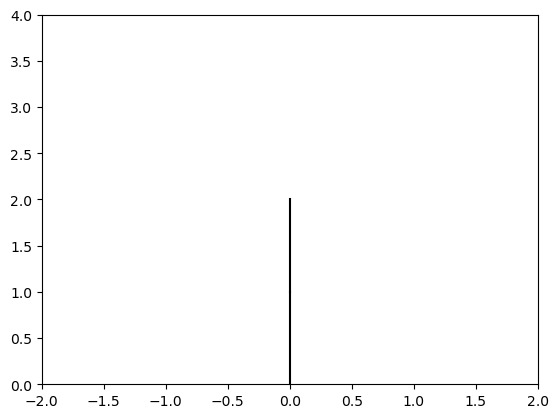

In [15]:
#animate it
import matplotlib.pyplot as plt
import matplotlib.animation as ani
from IPython.display import HTML
%matplotlib inline

fig1, ax1 = plt.subplots(1,1) #create axes

def plot_pendulum(i,m,ax): #update function for animation
    ax.clear()
    ax.set_xlim([-2,2])
    ax.set_ylim([0,4])
    
    #plot link 1
    L1topx = m.X0.value
    L1topy = m.Y0.value
    L1bottomx = m.X0.value + m.len[1]*np.sin(m.th[i,1].value)
    L1bottomy = m.Y0.value - m.len[1]*np.cos(m.th[i,1].value)    
    ax.plot([L1topx,L1bottomx],[L1topy,L1bottomy],color='xkcd:black')
    
    
    #plot link 2
    L2bottomx = L1bottomx + m.len[2]*np.sin(m.th[i,1].value + m.th[i,2].value)
    L2bottomy = L1bottomy - m.len[2]*np.cos(m.th[i,1].value + m.th[i,2].value) 
    ax.plot([L1bottomx,L2bottomx],[L1bottomy,L2bottomy],color='xkcd:black')
    
update = lambda i: plot_pendulum(i,m,ax1) #lambdify update function

animate = ani.FuncAnimation(fig1,update,range(1,N+1),interval = 50,repeat=True)

HTML(animate.to_html5_video()) #you need to convert the animation to HTML5 to embed it in the notebook
